Four different implementations of Fitz-Hugh Nagumo Reaction Diffusion CNN. PYCUDA implementation runs faster but other implements are considered as well (having simpler, fully Pythonic, descriptions): 
- NUMBA (a bit slower but fully described in Python) 
- NUMPY (quite fast using CPU only, useful for comparisons) 
- CUPY (supports GPU with a code almost identical with the one in NUMPY, relatively slow for GPU support) 

Relevant papers (drafts attached): Please cite them if you find the code useful for your research 

[1]  https://www.worldscientific.com/doi/abs/10.1142/S0218127498000152 

[2] R. Dogaru, "Applications of Emergent Computation in Reaction-Diffusion CNNs for Image Processing," 2013
19th International Conference on Control Systems and Computer Science, Bucharest, 2013, pp. 370-377, doi:
10.1109/CSCS.2013.39.  ( attached here as draft IAFA_2013_draft.pdf )

In that paper some examples for various dynamical regimes are given. 

[3] Radu Dogaru, Ioana Dogaru, "High Productivity Cellular Neural Network Implementation on GPUs using Python",  
published in Proceedings of the Workshop in Information Technology and Bionics (Symposium in Memory of Tamás Roska), Budapest, 23–24 June 2015, ISBN 978-963-89880-3-4, pp. 23-27
 
(attached here as draft CNN_simulator_2015_draft.pdf)



Copyright Radu and Ioana Dogaru; Last update 10 January 2021 

This may help !
https://wiki.tiker.net/PyCuda/Examples/GameOfLife/

In [1]:
#  Checking the GPU unit available 
#-------------------------------------------------------------------------

!nvidia-smi 
#
# 

Sun Jan 10 08:17:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pycuda
# Installing PYCUDA library 

     |████████████████████████████████| 1.6MB 12.8MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621122 sha256=1f850916395b7e2275afe4f604a0aea1190eb3c85eb3c695b9f29b38c67b048d
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2021.1-py2.py3-none-any.whl size=60415 sha256=558c09e2b0c76209e46ceb4fb94ee858e82083c2e814f98521add7d0b161ec1c
  Stored in directory: /root/.cache/pip/wheels/5d/85/10/7da05d77b47f2cb503e5c4185ba82187d0b6b6736b3c6641e0
Successfully built pycuda pytools


In [53]:
# CELL 1 
# Model parameters initialization - can be used for all implementations 
# 


def get_init_state(typ=1, img_size=512, name='test_pattern_1__.jpg', a=-0.1, b= 1.3, eps= -0.1, c=1, Du=0.5, Dv=1, dt=0.1):
# img_size  image (CNN array) size (for typ>2 - depends on specific image file)
# name nume fisier cu imaginea  
# typ - # initial state image  (1 - mid random square 11x11 size ; 2 all random;  3 image from a given file - e.g. test_pattern_1__.jpg  )0
  # ==============================================
  # Specific parameters of the reaction-difussion CNN (RD-CNN)
  ka=1
  #dt,    a,   b,     eps, c,   Du,   Dv, ka  =
  0.1, -0.1, 1.3, -0.1, 1.0, 0.5, 1, 1  
  # slow growth for image size 1024x1024 si typ=1
  #0.1, -0.1,   1.5,  -0.1, 1,  0.15,   1,  1 # various image processing (adjusting) a,b, Du, Dv  
  

  # - simulation parameters     
  NN = img_size  # dimensiunea imaginii (forma patrata)  - daca este generata aleatoriu 
  NM = NN   # imaginea (la momentul 0) este patrata si se genereaza aleatoriu 
         
  colmap='jet' # va fi automat 'gray' la utilizarea unei imagini ca stare initiala 
  if typ==3:
    colmap='gray'

  Pars=np.array([dt, a, b, eps, c, Du, Dv, ka], dtype=np.float32)  

  # calcul stari initiale 
  A = np.zeros((NN, NM), dtype=np.float32)
  B = np.zeros((NN, NM), dtype=np.float32)
  if typ==1:  
    r = 11
    A[NN//2-r:NN//2+r,NM//2-r:NM//2+r] = -0.5+np.random.random((2*r,2*r))
  elif typ==2:  
    A = -0.5+np.random.random((NN,NM)).astype('float32') 
    B = -0.5+np.random.random((NN,NM)).astype('float32')  
  elif typ==3: # citire imagine 
    x=mpimg.imread(name)
    if np.size(np.shape(x))==3:
      x=rgb2gray(x)
    ma=1.0*np.max(x)
    mi=1.0*np.min(x) 
    (NN,NM)=np.shape(x)   
    At=(-.5+(x-mi)/(ma-mi))
    A=ka*np.float32(At)  
    B=-np.copy(A)


  # Buffers for snapshots during running
  Anew = np.zeros((NN, NM), dtype=np.float32)
  Bnew = np.zeros((NN, NM), dtype=np.float32)   
   
  A_show= np.zeros((nsnp+1, NN, NM,), dtype=np.float32) 
  B_show= np.zeros((nsnp+1, NN, NM,), dtype=np.float32)
  A_show[0,:,:]=A
  B_show[0,:,:]=B
  return (Pars, A,B,Anew,Bnew,A_show,B_show,colmap)

def disp_simul(A_show,B_show,nsnp,iter_max, colmap, implement):
  ##
  (NN,NM)=np.shape(A_show)[1:3]
  cit=runtime/(NM*NN*iter_max)

  vmi=np.min(B_show)
  vma=np.max(B_show)
  vmia=np.min(A_show)
  vmaa=np.max(A_show)
 
  plt.clf()
  iter=0
  while iter < (nsnp+1):
    plt.subplot(2,nsnp+1,iter+1) 

 
    plt.imshow(A_show[iter,:,:],colmap,interpolation='none',vmin=vmia,vmax=vmaa)
    plt.axis('off')
    plt.title('Iter: '+str(iter*test_mod))
 
 
    plt.subplot(2,nsnp+1,nsnp+1+iter+1) 
    if iter == nsnp/2: 
      plt.title(implement + '\n Pars [dt, a, b, eps, c, Du, Dv \
      ka] : '+str(Pars)+'   Size: '+str([NN,NM])+\
      '\n ns/cell and iter : '+str(1e9*cit)+'\n vmin='+str(vmia)+' vmax='+str(vmaa))
 
 
    plt.imshow(B_show[iter,:,:],colmap,interpolation='none',vmin=vmi,vmax=vma)
    plt.axis('off')
 
    iter += 1

  print('==========================================================================')
  print ('per cell time: ', str(cit*1e9), 'nano-seconds')
  print ('speed:  ', str(1e-6/cit), 'Mega cells/second')
  print ('max-min=', str(np.max(A_show)-np.min(A_show)))
  print('==========================================================================')
  lastA=A_show[iter-1,:,:]
  lastB=B_show[iter-1,:,:]
  return(lastA,lastB)

def rgb2gray(rgb):  # Auxiliar pentru conversia in "gray" a imaginilor care sunt "color"
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

FHN Calculation: 512 x 512 mesh
Transfer GPU 0.003348827362060547
 1999, (elapsed: 0.057094 s)
 3999, (elapsed: 0.126305 s)
 5999, (elapsed: 0.193329 s)
 7999, (elapsed: 0.250551 s)
 9999, (elapsed: 0.311720 s)
 total: 0.313906 s
per cell time:  0.11974570952588692 nano-seconds
speed:   8351.029894593572 Mega cells/second
max-min= 3.1504402


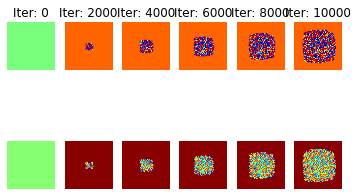

In [54]:
# CELL 2 
# Try a different approach 

''' 
PYCUDA-based RD_CNN simulator (check "GPU-ON" runtime if in Colab)
Last update: January 2021
More about finding local activity regions in https://www.worldscientific.com/doi/abs/10.1142/S0218127498000152
Possible extension - implementation of the Cellular Neural Network model 
About CNNs here:  http://www.scholarpedia.org/article/Cellular_neural_network

'''  

import numpy as np
import time
from string import Template 
import pycuda.autoinit
from pycuda.compiler import SourceModule
from pycuda import gpuarray

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

#================================  RUNNING DATA  ========================================
nsnp=5; iter_max=10000; test_mod=iter_max//nsnp 
(Pars, A,B,Anew,Bnew,A_show,B_show,colmap)=\
get_init_state()
#get_init_state(typ=1, img_size=128, name='test_pattern_1__.jpg', dt=0.1, a=-0.26,  b= 1.2,  eps=-0.1, c=1,  Du=0.6,   Dv=2)
#get_init_state()  # slow growth dynamics 

# --------- some particular cases ---- must be used as arguments in the above 
# typ=3, name='test_pattern_1__.jpg', dt=0.1, a=-0.1,  b= 1.5,  eps=-0.1, c=1,  Du=0.15,   Dv=1 # sort of edge det 


(NN,NM)=np.shape(A)
#===========================================================================
#===========================================================================
# Pycuda kernel ( Cod C-CUDA care este compilat de catre compilatorul nvcc )
# Implements the local rule of the CNN  
# 
src=Template("""
__global__ void ca_core_kernel(float *A, float *B, float *Anew, float *Bnew, float *Pars)
{

  // --- array size and cell indices 
  //int n_x = blockDim.x*gridDim.x;
  int n_x=$sizm;
  int i = threadIdx.x + blockDim.x*blockIdx.x;
  int j = threadIdx.y + blockDim.y*blockIdx.y;
  

  int i_left; int i_right; int j_down; int j_up;

  // Boundary conditions 
  if(i==0) {i_left=n_x-1;} else {i_left=i-1;}
  if(i==n_x-1) {i_right=0;} else {i_right=i+1;}
  if(j==0) {j_down=n_x-1;} else {j_down=j-1;}
  if(j==n_x-1) {j_up=0;} else {j_up=j+1;}

  int cen,dre,stg,sus,jos;
  cen=n_x*j+i; dre=j*n_x+i_right; stg=j*n_x+i_left; sus=j_up*n_x+i; jos=j_down*n_x+i;

  Anew[cen] = A[cen]+Pars[0]*(A[cen]*(Pars[4]-A[cen]*A[cen]/3)-B[cen]+ Pars[5]*( A[dre] +A[stg] +A[jos] + A[sus]-4*A[cen]));
  Bnew[cen]= B[cen]+Pars[0]*(-Pars[3]*(A[cen]-Pars[2]*B[cen]+Pars[1])+Pars[6]*(B[dre] +B[stg] + B[jos] +B[sus] -4*B[cen])); 

}
""")

# defining kernel function 

d={} 
d['sizn']=NN
d['sizm']=NM

mod = SourceModule(src.substitute(d)) # compilare kernel 
ca_core = mod.get_function("ca_core_kernel") # asociere functie de interfatare 

# ---- SIMULATION stage   --------------------------------------------------------- 
#=========================== PYCUDA implements  ===================================

print ( "FHN Calculation: %d x %d mesh" % (NN, NM))
timer = time.time()
#-------------- CUDA preparing -------------
blockdim = (32,32,1)  # my be optimized - product should not be larger than 1024


griddim = (NN//blockdim[0], NM//blockdim[1],1)   # 3D format  

# - transfer to  GPU (there we have A_gpu B_gpu in GPU's global memory)
t1=time.time()
A_gpu=gpuarray.to_gpu(A) 
Anew_gpu=gpuarray.to_gpu(Anew)
B_gpu=gpuarray.to_gpu(B) 
Bnew_gpu=gpuarray.to_gpu(Bnew)
Pars_gpu=gpuarray.to_gpu(Pars)
t2=time.time()
print('Transfer GPU', t2-t1)


#  MAIN LOOP

for iter in range(iter_max):
 # call of the kernel function 
 ca_core(A_gpu, B_gpu, Anew_gpu, Bnew_gpu, Pars_gpu, block=blockdim, grid=griddim)
 # prepare for a new iteration  
 A_gpu = Anew_gpu
 B_gpu = Bnew_gpu
 
 # snapshots transffered from GPU to  CPU 
 if (iter+1) % test_mod == 0:

  print ("%5d, (elapsed: %f s)" % (iter, time.time()-timer))
  A_show[1+iter//(test_mod),:,:]=Anew_gpu.get()
  B_show[1+iter//(test_mod),:,:]=Bnew_gpu.get()

runtime = time.time() - timer
print (" total: %f s" % runtime)

# ================ visualization  
(lA,lB)=disp_simul(A_show,B_show,nsnp,iter_max, colmap, 'PYCUDA')


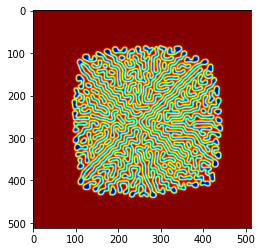

In [55]:
# Display last plotted image 
plt.clf(); 
plt.imshow(lB,colmap)


FHN Calculation: 512 x 512 mesh
 1999, (elapsed: 0.952187 s)
 3999, (elapsed: 1.531093 s)
 5999, (elapsed: 2.114593 s)
 7999, (elapsed: 2.706407 s)
 9999, (elapsed: 3.272402 s)
 total: 3.273334 s
per cell time:  1.2486777450249065 nano-seconds
speed:   800.8471392913739 Mega cells/second
max-min= 3.1560416


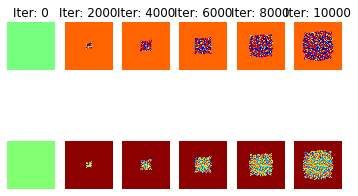

In [56]:
# CELL 3 / NUMBA IMPLEMENTATION 
''' 

NUMBA implement - sometimes you have to wait until Colab offers full access 

'''  


import numpy as np
import time
from numba import cuda, jit 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg   # pentru imread imwrite etc.. 


#================================  DATE RULARE ========================================
nsnp=5; iter_max=10000; test_mod=iter_max//nsnp 
(Pars, A,B,Anew,Bnew,A_show,B_show,colmap)=\
get_init_state()
#get_init_state(typ=1, img_size=128, name='test_pattern_1__.jpg', dt=0.1, a=-0.26,  b= 1.2,  eps=-0.1, c=1,  Du=0.6,   Dv=2)
#get_init_state(typ=3, name='test_pattern_1__.jpg', dt=0.1, a=-0.1,  b= 1.5,  eps=-0.1, c=1,  Du=0.15,   Dv=1)
#get_init_state()
#get_init_state(typ=1, img_size=1024, name='test_pattern_1__.jpg', a=-0.1, b=1.5, eps= -0.1, c=.7, Du=0.5, Dv=1, dt=0.1)

(NN,NM)=np.shape(A)
#==================================================================================

#===============  DEFINIRE CUDA Kernel !!!  ======================================================

@cuda.jit
def ca_core(A, B, Anew, Bnew, Pars):
  
    n = A.shape[0]
    m = A.shape[1]
    
    # thread distribution of the cell implementation 
    j = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x 
    i = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y 
    if (j >= 0 and j < n) and (i >= 0 and i < m) :  # GPU equivalent of for loops in CPU
 
            Anew[j, i] = A[j,i]+Pars[0]*(A[j,i]*(Pars[4]-A[j,i]*A[j,i]/3)-B[j,i]+ \
            Pars[5]*( A[j,(i+1)%m] +A[j,(i-1)%m] +A[(j-1)%n, i] + A[(j+1)%n,i]-4*A[j,i]) )
            Bnew[j,i]= B[j,i]+Pars[0]*(-Pars[3]*(A[j,i]-Pars[2]*B[j,i]+Pars[1])+ \
            Pars[6]*(B[j,(i+1)%m] +B[j,(i-1)%m] + B[(j-1)%n,i] +B[(j+1)%n,i] -4*B[j,i]))
       


#-------------- CUDA preparing -------------
print ( "FHN Calculation: %d x %d mesh" % (NN, NM))
timer = time.time()
blockdim = (32,32)  # the exact value must be optimized  
griddim = (NN//blockdim[0], NM//blockdim[1])  

dA = cuda.to_device(A)        
dAnew = cuda.to_device(Anew)    
dB = cuda.to_device(B)          
dBnew = cuda.to_device(Bnew)    
dPars = cuda.to_device(Pars) 

# Main loop (dynamics of the CNN system)
iter = 0
while iter < iter_max:
 ca_core[griddim, blockdim](dA, dB, dAnew, dBnew, dPars)
 # prepare input data for the new iteration  
 dA = dAnew
 dB = dBnew
 
 # memory transfer from GPU to CPU 
 if (iter+1) % test_mod == 0:

  dAnew.to_host() 
  dBnew.to_host()
  
  print ("%5d, (elapsed: %f s)" % (iter, time.time()-timer))
  A_show[1+iter//(test_mod),:,:]=Anew
  B_show[1+iter//(test_mod),:,:]=Bnew
  
 iter += 1

runtime = time.time() - timer
print (" total: %f s" % runtime)
# ================ partea de vizualizare ==  identica la toate implementarile 
(lA,lB)=disp_simul(A_show,B_show,nsnp,iter_max, colmap, 'NUMBA / GPU ')

FHN Calculation: 512 x 512 mesh
 1999, (elapsed: 9.362524 s)
 3999, (elapsed: 18.495139 s)
 5999, (elapsed: 27.735461 s)
 7999, (elapsed: 36.968689 s)
 9999, (elapsed: 46.149732 s)
 total: 46.150776 s
per cell time:  17.60512404871406 nano-seconds
speed:   56.80164463669561 Mega cells/second
max-min= 3.281227


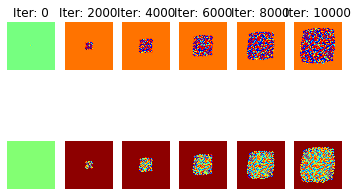

In [57]:
# CELL4 - NUMPY (CPU only)

#================================  DATE RULARE ========================================
nsnp=5; iter_max=10000; test_mod=iter_max//nsnp 
(Pars, A,B,Anew,Bnew,A_show,B_show,colmap)=\
get_init_state()
#get_init_state(typ=1, img_size=128, name='test_pattern_1__.jpg', dt=0.1, a=-0.26,  b= 1.2,  eps=-0.1, c=1,  Du=0.6,   Dv=2)
#get_init_state(typ=3, name='test_pattern_1__.jpg', dt=0.1, a=-0.1,  b= 1.5,  eps=-0.1, c=1,  Du=0.15,   Dv=1)
#get_init_state()
(NN,NM)=np.shape(A)
#==================================================================================


def ca_core_npy(A, B, Pars):

  #x=Pars[0]*( A*(Pars[4]-A*A/3) 
  Anew = A+Pars[0]*(A*(Pars[4]-A*A/3)-B +Pars[5]*(np.roll(A,-1,0)+np.roll(A,1,0)+np.roll(A,-1,1)+np.roll(A,1,1)-4*A ))
  Bnew= B+Pars[0]*( -Pars[3]*(A-Pars[2]*B+Pars[1])  + Pars[6]*(np.roll(B,-1,0)+np.roll(B,1,0)+np.roll(B,-1,1)+np.roll(B,1,1)-4*B ))
  return (Anew, Bnew)
#  MAIN LOOP  
print ( "FHN Calculation: %d x %d mesh" % (NN, NM))
timer = time.time()


for iter in range(iter_max):
 # call one-step CA running 
 (A,B)=ca_core_npy(A, B, Pars)
 # outputs become inputs 
 
 
 # snapshots for display 
 if (iter+1) % test_mod == 0:

  print ("%5d, (elapsed: %f s)" % (iter, time.time()-timer))
  A_show[1+iter//(test_mod),:,:]=A
  B_show[1+iter//(test_mod),:,:]=B

runtime = time.time() - timer
print (" total: %f s" % runtime)

# ================ partea de vizualizare ==  identica la toate implementarile 
(lA,lB)=disp_simul(A_show,B_show,nsnp,iter_max, colmap, 'NUMPY (CPU)')

FHN Calculation: 512 x 512 mesh
 1999, (elapsed: 1.830668 s)
 3999, (elapsed: 3.654830 s)
 5999, (elapsed: 5.527292 s)
 7999, (elapsed: 7.337933 s)
 9999, (elapsed: 9.166473 s)
 total: 9.168243 s
per cell time:  3.4974070331372786 nano-seconds
speed:   285.9261134106459 Mega cells/second
max-min= 3.2218742


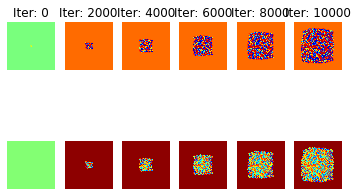

In [58]:
# CELL5 - CUPY (GPU only)
import cupy as cp 

#================================  DATE RULARE ========================================
nsnp=5; iter_max=10000; test_mod=iter_max//nsnp 
(Pars, A,B,Anew,Bnew,A_show,B_show,colmap)=\
get_init_state()
#get_init_state(typ=1, img_size=128, name='test_pattern_1__.jpg', dt=0.1, a=-0.26,  b= 1.2,  eps=-0.1, c=1,  Du=0.6,   Dv=2)
#get_init_state(typ=3, name='test_pattern_1__.jpg', dt=0.1, a=-0.1,  b= 1.5,  eps=-0.1, c=1,  Du=0.15,   Dv=1)

(NN,NM)=np.shape(A)
#==================================================================================

#===============  DEFINITION OF CUDA-based one CA iteration 
# Note that it is quite the same as in NUMPY   ======================================================

def ca_core_cpy(Ag, Bg, Parsg):

  
  Anewg = Ag+Parsg[0]*(Ag*(Parsg[4]-Ag*Ag/3)-Bg +Parsg[5]*(cp.roll(Ag,-1,0)+cp.roll(Ag,1,0)+cp.roll(Ag,-1,1)+cp.roll(Ag,1,1)-4*Ag ))
  Bnewg= Bg+Parsg[0]*( -Parsg[3]*(Ag-Parsg[2]*Bg+Parsg[1])  + Parsg[6]*(cp.roll(Bg,-1,0)+cp.roll(Bg,1,0)+cp.roll(Bg,-1,1)+cp.roll(Bg,1,1)-4*Bg ))
  Ag = Anewg
  Bg = Bnewg
  return (Ag,Bg)

#  Main loop 
print ( "FHN Calculation: %d x %d mesh" % (NN, NM))

Ag=cp.array(A)
Bg=cp.array(B)
Anewg=cp.array(Anew)
Bnewg=cp.array(Bnew)
Parsg=cp.array(Pars)


timer = time.time()
for iter in range(iter_max):
 # One step iteration 
 (Ag,Bg)=ca_core_cpy(Ag, Bg, Parsg)
 # Output becomes input (variables Ag Bg are stored on GPU's global memory ) 

 
 # la anumite momente se preiau "instantaneele" din GPU in memoria CPU 
 if (iter+1) % test_mod == 0:

  print ("%5d, (elapsed: %f s)" % (iter, time.time()-timer))
  A_show[1+iter//(test_mod),:,:]=cp.asnumpy(Ag)
  B_show[1+iter//(test_mod),:,:]=cp.asnumpy(Bg)

runtime = time.time() - timer
print (" total: %f s" % runtime) 
#=============================================================================================
# ================ partea de vizualizare ==  identica la toate implementarile 

(lA,lB)=disp_simul(A_show,B_show,nsnp,iter_max, colmap, 'CUPY (GPU)')

 total: 0.181732 s
per cell time:  0.06932514224899933 nano-seconds
speed:   14424.781075936911 Mega cells/second
7470 live cells after 10000 iterations


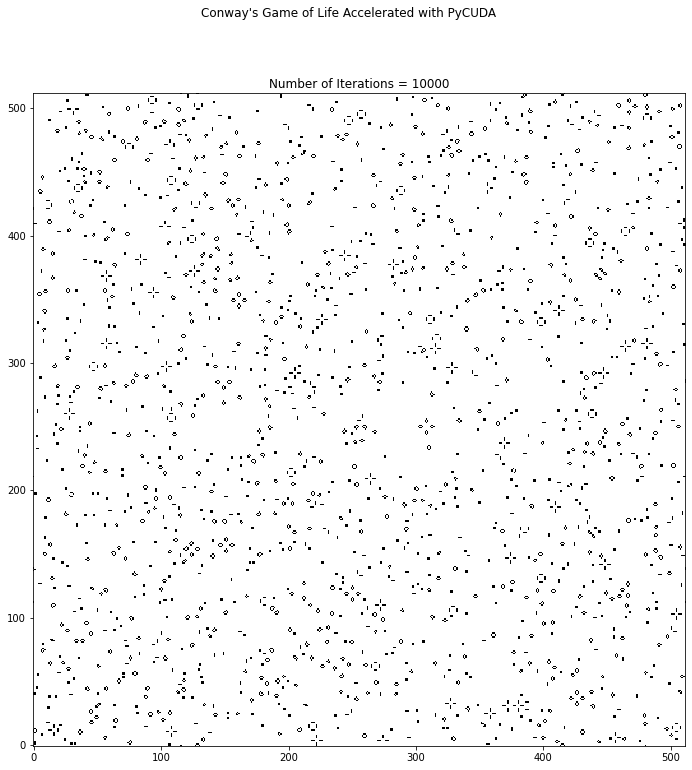

<Figure size 432x288 with 0 Axes>

In [74]:
# Adapted example from https://wiki.tiker.net/PyCuda/Examples/GameOfLife/
# May be used for further CA developments 


# Conway's Game of Life Accelerated with PyCUDA
# Luis Villasenor
# lvillasen@gmail.com
# 3/26/2016
# Licence: GPLv3
# Usage: python GameOfLife.py n n_iter
# where n is the board size and n_iter the number of iterations
import pycuda.driver as cuda
import pycuda.tools
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import sys
import numpy as np
from pylab import cm as cm
import matplotlib.pyplot as plt
n=512
n_iter=10000
n_block=32

n_grid=int(n/n_block);
n=n_block*n_grid;
def random_init(n):
    #np.random.seed(100)
    M=np.zeros((n,n)).astype(np.int32)
    for i in range(n):
        for j in range(n):
            M[j,i]=np.int32(np.random.randint(2))
    return M
mod = SourceModule("""
__global__ void step(int *C, int *M)
{
  int count;
  int n_x = blockDim.x*gridDim.x;
  int i = threadIdx.x + blockDim.x*blockIdx.x;
  int j = threadIdx.y + blockDim.y*blockIdx.y;
  int threadId = j*n_x+i;
  int i_left; int i_right; int j_down; int j_up;
  if(i==0) {i_left=n_x-1;} else {i_left=i-1;}
  if(i==n_x-1) {i_right=0;} else {i_right=i+1;}
  if(j==0) {j_down=n_x-1;} else {j_down=j-1;}
  if(j==n_x-1) {j_up=0;} else {j_up=j+1;}
  count = C[j*n_x+i_left] + C[j_down*n_x+i]
    + C[j*n_x+i_right] + C[j_up*n_x+i] + C[j_up*n_x+i_left]
    + C[j_down*n_x+i_right] + C[j_down*n_x+i_left]
    + C[j_up*n_x+i_right];

// Modify matrix M according to the rules B3/S23:
//A cell is "Born" if it has exactly 3 neighbours,
//A cell "Survives" if it has 2 or 3 living neighbours; it dies otherwise.
  if(count < 2 || count > 3) M[threadId] = 0; // cell dies
  if(count == 2) M[threadId] = C[threadId];// cell stays the same
  if(count == 3) M[threadId] = 1; // cell either stays alive, or is born
}
""")
func = mod.get_function("step")
C=random_init(n)
M = np.empty_like(C)
C_gpu = gpuarray.to_gpu( C )
M_gpu = gpuarray.to_gpu( M )

timer = time.time()

for k in range(n_iter):
  func(C_gpu,M_gpu,block=(n_block,n_block,1),grid=(n_grid,n_grid,1))
  C_gpu, M_gpu = M_gpu, C_gpu

runtime = time.time() - timer
print (" total: %f s" % runtime)

cit=runtime/(n*n*n_iter)
print('==========================================================================')
print ('per cell time: ', str(cit*1e9), 'nano-seconds')
print ('speed:  ', str(1e-6/cit), 'Mega cells/second')
print('==========================================================================')

print("%d live cells after %d iterations" %(np.sum(C_gpu.get()),n_iter))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
fig.suptitle("Conway's Game of Life Accelerated with PyCUDA")
ax.set_title('Number of Iterations = %d'%(n_iter))
myobj =plt.imshow(C_gpu.get(),origin='lower',cmap='Greys',  interpolation='nearest',vmin=0, vmax=1)
plt.pause(.01)
plt.draw()
